Main Version

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def generate_item_list():
    dataset = []
    for i in range(10):
        for j in range(10):
            dataset.append(chr(ord('A') + i) + str(j))
    return dataset

def generate_dataset(item_list, X, Y, min_items, max_items):
    num_items = np.random.randint(min_items, max_items+1)
    items = np.random.choice(item_list, size=num_items, replace=False)

    timestamps = []
    current_timestamp = 0

    for _ in range(num_items):
        timestamps.append(current_timestamp)
        current_timestamp += np.random.uniform(X, Y)

        if np.random.rand() < 0.5:
            gap_size = np.random.uniform(X, Y) + np.random.uniform(Y, Y+20)
            current_timestamp += gap_size

    timestamps = np.round(timestamps, 2)
    return items, timestamps

# Generate sample data; x and y is the range for the number of timestamps generated before a bigger gap to simulate natural clustering
X = 2
Y = 5
min_items = 5
max_items = 30

item_list = generate_item_list()
items, timestamps = generate_dataset(item_list, X, Y, min_items, max_items)

for i in range(len(items)):
    print(f"{items[i]} - {timestamps[i]}")

# Plot the timestamps
plt.figure(figsize=(12, 6))
plt.plot(timestamps, range(len(items)), 'bo')
plt.yticks(range(len(items)), items)
plt.xlabel('Timestamp')
plt.ylabel('Items')
plt.title('Generated Data')
plt.show()

# Apply k-means clustering and find the optimal k value using the Silhouette Score
silhouette_scores = []
unique_samples = len(np.unique(timestamps))
max_k = min(len(timestamps), 10)
for k in range(3, min(max_k+1, unique_samples)):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=0).fit(timestamps.reshape(-1, 1))
    cluster_labels = kmeans.labels_
    silhouette_scores.append(silhouette_score(timestamps.reshape(-1, 1), cluster_labels))

# Plot the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range(3, len(silhouette_scores)+3), silhouette_scores, 'bo-', markersize=8, lw=2)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores')

# Calculate the optimal k value using the Silhouette Score
k_optimal = silhouette_scores.index(max(silhouette_scores)) + 3
plt.plot(k_optimal, silhouette_scores[k_optimal-3], 'ro', markersize=8)
plt.annotate(f'Optimal k={k_optimal}', (k_optimal, silhouette_scores[k_optimal-3]), xytext=(k_optimal+1, silhouette_scores[k_optimal-3]))
plt.show()

# Apply k-means clustering with optimal k value
kmeans_optimal = KMeans(n_clusters=k_optimal, n_init=10, random_state=0).fit(timestamps.reshape(-1, 1))
cluster_labels = kmeans_optimal.predict(timestamps.reshape(-1, 1))

# Sort items and timestamps based on cluster labels
sorted_indices = np.argsort(cluster_labels)
sorted_items = np.array(items)[sorted_indices]
sorted_timestamps = np.array(timestamps)[sorted_indices]
sorted_cluster_labels = cluster_labels[sorted_indices]

# Create colormap for clusters
colormap = cm.viridis

# Plot the timestamps with color according to cluster
plt.figure(figsize=(12, 6))
for i in range(len(items)):
    plt.plot(timestamps[i], i, 'o', c=colormap(cluster_labels[i] / (k_optimal-1)), label=f'Cluster {cluster_labels[i]+1}')

plt.yticks(range(len(items)), items)
plt.xlabel('Timestamp')
plt.ylabel('Items')
plt.title('Generated Data (Colored by Cluster)')
plt.legend()
plt.show()

# Print the generated data and cluster labels
for i in range(len(items)):
    print(f"{items[i]} - {timestamps[i]} - Cluster: {cluster_labels[i]+1}")

Heatmap Version

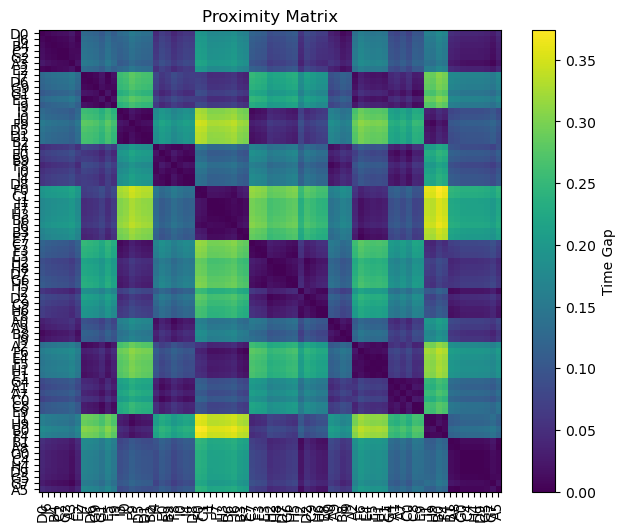

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def generate_item_list():
    dataset = []
    for i in range(10):
        for j in range(10):
            dataset.append(chr(ord('A') + i) + str(j))
    return dataset

def generate_dataset(item_list, X, Y, min_items, max_items, proximity_memory):
    num_items = np.random.randint(min_items, max_items+1)
    items = np.random.choice(item_list, size=num_items, replace=False)
    
    timestamps = []
    current_timestamp = 0
    proximity_dict = {}
    
    for _ in range(num_items):
        timestamps.append(current_timestamp)
        proximity_dict[current_timestamp] = []
        current_timestamp += np.random.uniform(X, Y)

    timestamps = np.round(timestamps, 2)

    if len(timestamps) > 1:
        # Update proximity dictionary based on previous cluster labels
        sorted_indices = np.argsort(timestamps)
        sorted_timestamps = timestamps[sorted_indices]
        sorted_items = items[sorted_indices]
        sorted_labels = np.zeros_like(timestamps)
        for i in range(len(sorted_items)):
            item = sorted_items[i]
            timestamp = sorted_timestamps[i]

            if timestamp in proximity_memory:
                proximity_memory[timestamp].append(item)
            else:
                proximity_memory[timestamp] = [item]

            if i < len(sorted_items) - 1:
                next_item = sorted_items[i + 1]
                next_timestamp = sorted_timestamps[i + 1]

                gap = np.abs(float(next_timestamp) - float(timestamp))
                if gap in proximity_memory:
                    proximity_memory[gap].append((item, next_item))
                else:
                    proximity_memory[gap] = [(item, next_item)]

            sorted_labels[i] = len(proximity_memory[timestamp])

        return items, timestamps, proximity_dict, sorted_labels

    return items, timestamps, proximity_dict, np.zeros_like(timestamps)

# Initialize proximity memory
proximity_memory = {}

# Initialize empty proximity matrix
proximity_matrix = None

# Run cycles
for cycle in range(1, 101):
    # Generate new dataset
    item_list = generate_item_list()
    X = 0
    Y = 1
    min_items = 50
    max_items = 100
    items, timestamps, proximity_dict, cluster_labels = generate_dataset(item_list, X, Y, min_items, max_items, proximity_memory)

    # Apply k-means clustering with optimal k value
    k_optimal = max(2, len(set(cluster_labels)))
    kmeans_optimal = KMeans(n_clusters=k_optimal, n_init=10, random_state=0).fit(timestamps.reshape(-1, 1))
    cluster_labels = kmeans_optimal.labels_

    # Sort items and timestamps based on cluster labels
    sorted_indices = np.argsort(cluster_labels)
    sorted_items = np.array(items)[sorted_indices]
    sorted_timestamps = np.array(timestamps)[sorted_indices]
    sorted_cluster_labels = cluster_labels[sorted_indices]

    # Update proximity dictionary with new cluster labels
    for i in range(len(sorted_items)):
        item1 = sorted_items[i]
        timestamp1 = sorted_timestamps[i]
        if timestamp1 in proximity_memory:
            proximity_memory[timestamp1].append(item1)
        else:
            proximity_memory[timestamp1] = [item1]
        if i < len(sorted_items) - 1:
            item2 = sorted_items[i+1]
            timestamp2 = sorted_timestamps[i+1]
            gap = np.abs(float(timestamp2) - float(timestamp1))
            if gap in proximity_memory:
                proximity_memory[gap].append((item1, item2))
            else:
                proximity_memory[gap] = [(item1, item2)]

    # Adjust clustering based on proximity memory
    accepted_gap = True
    if accepted_gap:
        proximity_clusters = {}
        for gap, items_pairs in proximity_memory.items():
            if isinstance(gap, tuple):
                item1, item2 = gap[0], gap[1]
                if item1 not in proximity_clusters:
                    proximity_clusters[item1] = [item1, item2]
                else:
                    proximity_clusters[item1].append(item2)
                if item2 not in proximity_clusters:
                    proximity_clusters[item2] = [item2, item1]
                else:
                    proximity_clusters[item2].append(item1)

        # Update cluster labels based on proximity clusters
        for i in range(len(sorted_items)):
            item = sorted_items[i]
            if item in proximity_clusters:
                closest_item = min(proximity_clusters[item], key=lambda x: np.abs(sorted_timestamps[i] - sorted_timestamps[np.where(sorted_items == x)][0]))
                closest_index = np.where(sorted_items == closest_item)[0][0]
                sorted_cluster_labels[closest_index] = sorted_cluster_labels[i]

    # Re-sort items and timestamps based on updated cluster labels
    sorted_indices = np.argsort(sorted_cluster_labels)
    sorted_items = sorted_items[sorted_indices]
    sorted_timestamps = sorted_timestamps[sorted_indices]
    sorted_cluster_labels = sorted_cluster_labels[sorted_indices]

    # Assign new cluster labels to items and timestamps
    items = sorted_items
    timestamps = sorted_timestamps
    cluster_labels = sorted_cluster_labels

    # Update proximity matrix
    proximity_matrix_size = len(items)  # Update size based on updated items
    if proximity_matrix is None or proximity_matrix.shape != (proximity_matrix_size, proximity_matrix_size):
        proximity_matrix = np.zeros((proximity_matrix_size, proximity_matrix_size))
    for i in range(len(items)):
        for j in range(i+1, len(items)):
            item1 = items[i]
            item2 = items[j]
            time_gap = np.abs(float(timestamps[i]) - float(timestamps[j]))
            proximity_matrix[i][j] += time_gap
            proximity_matrix[j][i] += time_gap  

# Normalize proximity matrix
normalized_proximity_matrix = proximity_matrix / 100

# Plot the proximity matrix
plt.figure(figsize=(8, 6))
plt.imshow(normalized_proximity_matrix, cmap='viridis')
plt.title('Proximity Matrix')
plt.colorbar(label='Time Gap')
plt.xticks(range(len(items)), items, rotation=90)
plt.yticks(range(len(items)), items)
plt.show()